In [1]:
DATA_PATH = "./data/"
OUTPUT_PATH = "./out/"

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sklearn
import sklearn.ensemble 
import sklearn.metrics
import time

from sklearn.externals import joblib

colorDic = {"blue" : "#6599FF", "yellow" : "#FFAD33",  "purple": "#683b96", "green" : "#198D6D", "red" : "#FF523F"}
colors = list(colorDic.values())
pxToMm= 0.19

In [3]:
dfStim = pd.read_pickle(DATA_PATH  + "data_03_stim.pkl")

In [4]:
dfStim["RelativeTimePeak"] = dfStim.TimeRelativ -dfStim.TimePeak
dfStim = dfStim[dfStim.IsBumpVirtual == True]
dfStim = dfStim[dfStim.TouchType == 2]
dfStim = dfStim[dfStim.TimePeak >= 0]
TouchEventId = dfStim.groupby(["TouchId"])["TouchEventId"].max().values
dfStim = dfStim[dfStim.TouchEventId.isin(TouchEventId)]
dfStim.TouchOffset.describe()

count    4236.000000
mean       50.654622
std        34.759247
min         0.633333
25%        24.463397
50%        42.713623
75%        68.812181
max       180.249827
Name: TouchOffset, dtype: float64

In [5]:
split = (65, 22, 22)
ps = np.array(sorted(dfStim.PId.unique()))
num_pt = len(ps)
x1 = (int)(np.floor(len(ps) * split[1] / 100.0))
x2 = (int)(np.floor(len(ps) * split[2] / 100.0))
split_train = ps[x2+x1:]
split_test = ps[x1:x1+x2]
split_validation = ps[:x2]

dfTrain = dfStim[dfStim.PId.isin(split_train) & (dfStim.VisualStimuliPositionX != sorted(dfStim.VisualStimuliPositionX.unique())[2])& (dfStim.VisualStimuliPositionY != sorted(dfStim.VisualStimuliPositionY.unique())[2])]
dfTest = dfStim[dfStim.PId.isin(split_test)]
dfValidation = dfStim[dfStim.PId.isin(split_validation)]
print("Participants in the validation data set %s" % split_validation)
print("Participants in the       test data set %s" % split_test)
print("Participants in the      train data set %s" % split_train)

Participants in the validation data set [1 3 5]
Participants in the       test data set [6 7 8]
Participants in the      train data set [ 9 10 11 12 13 14 15 16 17 18]


In [6]:
%%time
def RandomForestRegressor(direction, n_estimators, max_features):
    if (direction == "X"):
        X = dfTrain[["SpeedCondition", "TouchX", "TouchY", 'Acc', 'RelativeTimePeak', "PeakValue"]].values
        y = dfTrain.TouchOffsetX.values
    elif (direction == "Y"):
        X = dfTrain[["SpeedCondition", "TouchX", "TouchY", 'Acc', 'RelativeTimePeak', "PeakValue"]].values
        y = dfTrain.TouchOffsetY.values
    
    model = sklearn.ensemble.RandomForestRegressor(n_estimators=int(n_estimators),
                                       max_features=int(max_features))
    #model.fit(min_max_scaler.transform(X), y)
    model.fit(X, y)
    #X_test = min_max_scaler.transform(dfTest[["SpeedCondition", "TouchX", "TouchY", 'Acc', 'RelativeTimePeak', 'PeakValue']].values)
    X_test = dfTest[["SpeedCondition", "TouchX", "TouchY", 'Acc', 'RelativeTimePeak', 'PeakValue']].values
    y_rbf = model.predict(X_test)
    df = dfTest.copy()
    if (direction == "X"):
        df["TouchOffsetXPred"] = y_rbf
        score = model.score(X_test, df.TouchOffsetX.values)
        rmse = np.sqrt(sklearn.metrics.mean_squared_error(df.TouchOffsetX.values, df.TouchOffsetXPred))
        m = (df.TouchX-df.VisualStimuliPositionX-df.TouchOffsetXPred).mean()
        sd = (df.TouchX-df.VisualStimuliPositionX-df.TouchOffsetXPred).std()
        return (model, direction, n_estimators, max_features, score, rmse, m, sd)
    elif (direction == "Y"):
        df["TouchOffsetYPred"] = y_rbf
        score = model.score(X_test, df.TouchOffsetY.values)
        rmse = np.sqrt(sklearn.metrics.mean_squared_error(df.TouchOffsetY.values, df.TouchOffsetYPred))
        m = (df.TouchY-df.VisualStimuliPositionY-df.TouchOffsetYPred).mean()
        sd = (df.TouchY-df.VisualStimuliPositionY-df.TouchOffsetYPred).std()
        return (model, direction, n_estimators, max_features, score, rmse, m, sd)

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 15 µs


In [7]:
%%time
lst = []
for direction in ["X", "Y"]:
    RMSE = np.infty
    for n_estimators in range(10, 30):
        for max_features in range(1, 7):
            start = time.time()
            for runs in range(100):
                model, direction, n_estimators, max_features, score, rmse, m, sd = RandomForestRegressor(direction, n_estimators, max_features)
                if RMSE > rmse:
                    RMSE = rmse
                    #joblib.dump(model, '%s/Model_RF_%s.pkl' % (OUTPUT_PATH, direction)) 
                lst.append((direction, n_estimators, max_features, score, rmse, m, sd ))
            stop = time.time()
            print("n_estimators %i max_features %i time: %i" % (n_estimators, max_features, (stop-start)))

n_estimators 10 max_features 1 time: 3
n_estimators 10 max_features 2 time: 4
n_estimators 10 max_features 3 time: 4
n_estimators 10 max_features 4 time: 5
n_estimators 10 max_features 5 time: 6
n_estimators 10 max_features 6 time: 6
n_estimators 11 max_features 1 time: 3
n_estimators 11 max_features 2 time: 4
n_estimators 11 max_features 3 time: 5
n_estimators 11 max_features 4 time: 6
n_estimators 11 max_features 5 time: 6
n_estimators 11 max_features 6 time: 7
n_estimators 12 max_features 1 time: 3
n_estimators 12 max_features 2 time: 4
n_estimators 12 max_features 3 time: 5
n_estimators 12 max_features 4 time: 6
n_estimators 12 max_features 5 time: 7
n_estimators 12 max_features 6 time: 7
n_estimators 13 max_features 1 time: 3
n_estimators 13 max_features 2 time: 5
n_estimators 13 max_features 3 time: 6
n_estimators 13 max_features 4 time: 7
n_estimators 13 max_features 5 time: 8
n_estimators 13 max_features 6 time: 8
n_estimators 14 max_features 1 time: 4
n_estimators 14 max_featu

n_estimators 24 max_features 6 time: 11
n_estimators 25 max_features 1 time: 5
n_estimators 25 max_features 2 time: 7
n_estimators 25 max_features 3 time: 9
n_estimators 25 max_features 4 time: 10
n_estimators 25 max_features 5 time: 11
n_estimators 25 max_features 6 time: 12
n_estimators 26 max_features 1 time: 6
n_estimators 26 max_features 2 time: 8
n_estimators 26 max_features 3 time: 9
n_estimators 26 max_features 4 time: 11
n_estimators 26 max_features 5 time: 12
n_estimators 26 max_features 6 time: 12
n_estimators 27 max_features 1 time: 6
n_estimators 27 max_features 2 time: 8
n_estimators 27 max_features 3 time: 10
n_estimators 27 max_features 4 time: 11
n_estimators 27 max_features 5 time: 12
n_estimators 27 max_features 6 time: 12
n_estimators 28 max_features 1 time: 6
n_estimators 28 max_features 2 time: 8
n_estimators 28 max_features 3 time: 10
n_estimators 28 max_features 4 time: 12
n_estimators 28 max_features 5 time: 12
n_estimators 28 max_features 6 time: 13
n_estimato

In [8]:
df2 = pd.DataFrame(lst, columns=["Direction", "n_estimators", "max_features", "Score", "RMSE", "M", "SD"])

In [10]:
df2[df2.Direction == "X"].sort_values("RMSE").head().round(2)

,Direction,n_estimators,max_features,Score,RMSE,M,SD
5695,X,19,3,0.45,27.74,1.43,27.72
6831,X,21,3,0.44,27.83,0.73,27.84
5684,X,19,3,0.44,27.88,0.84,27.88
11691,X,29,3,0.44,27.91,1.96,27.86
8092,X,23,3,0.44,27.92,1.65,27.89


In [12]:
df2[df2.Direction == "Y"].sort_values("RMSE").head().round(2)

,Direction,n_estimators,max_features,Score,RMSE,M,SD
21790,Y,26,2,0.25,41.82,-10.31,40.56
13939,Y,13,2,0.25,41.85,-9.72,40.73
12175,Y,10,2,0.24,41.97,-11.65,40.34
23595,Y,29,2,0.24,42.10,-11.13,40.62
12122,Y,10,2,0.24,42.11,-10.59,40.78


In [13]:
joblib.load('%s/Model_RF_%s.pkl' % (OUTPUT_PATH, "X"))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=19, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [14]:
joblib.load('%s/Model_RF_%s.pkl' % (OUTPUT_PATH, "Y"))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=26, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

X
X 0.4469550704611944 27.740068993991844 17.590499590499576 21.46279718680837


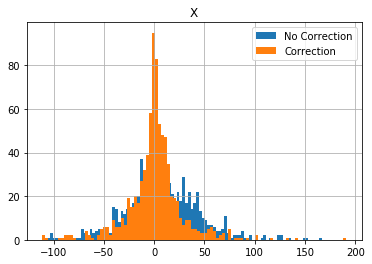

Y
Y 0.24780084224342447 41.8240640366161 29.62323599823593 29.542993132153757


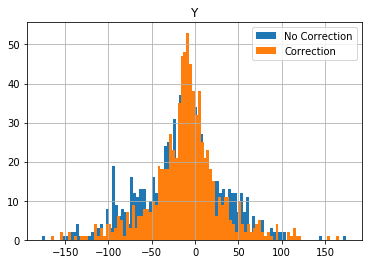

In [17]:
df = dfTest.copy()
lst = []
for direction in ["X", "Y"]:
    print (direction)
    model = joblib.load('%s/Model_RF_%s.pkl' % (OUTPUT_PATH, direction)) 
    
    X_test = dfTest[["SpeedCondition", "TouchX", "TouchY", 'Acc', 'RelativeTimePeak', 'PeakValue']].values
    y_rbf = model.predict(X_test)
    if (direction == "X"):
        df["TouchOffsetXPred"] = y_rbf
        score = model.score(X_test, df.TouchOffsetX.values)
        rmse = np.sqrt(sklearn.metrics.mean_squared_error(df.TouchOffsetX.values, df.TouchOffsetXPred))
        m = (df.TouchX-df.VisualStimuliPositionX-df.TouchOffsetXPred).abs().mean()
        sd = (df.TouchX-df.VisualStimuliPositionX-df.TouchOffsetXPred).abs().std()
        
    elif (direction == "Y"):
        df["TouchOffsetYPred"] = y_rbf
        score = model.score(X_test, df.TouchOffsetY.values)
        rmse = np.sqrt(sklearn.metrics.mean_squared_error(df.TouchOffsetY.values, df.TouchOffsetYPred))
        m = (df.TouchY-df.VisualStimuliPositionY-df.TouchOffsetYPred).abs().mean()
        sd = (df.TouchY-df.VisualStimuliPositionY-df.TouchOffsetYPred).abs().std()
    lst.append([rmse, m, sd])
    print (direction, score, rmse, m, sd)
    
    if (direction == "X"):
        (df.TouchX-df.VisualStimuliPositionX).hist(bins=100, label="No Correction")
        (df.TouchX-df.VisualStimuliPositionX-df.TouchOffsetXPred).hist(bins=100, label="Correction")
    else:
        (df.TouchY-df.VisualStimuliPositionY).hist(bins=100, label="No Correction")
        (df.TouchY-df.VisualStimuliPositionY-df.TouchOffsetYPred).hist(bins=100, label="Correction")
    plt.title(direction)
    plt.legend()
    plt.show()

In [18]:
lstBaseline = []

lstBaseline.append(np.sqrt(sklearn.metrics.mean_squared_error(dfTest.TouchX.values, dfTest.VisualStimuliPositionX)))
lstBaseline.append(dfTest.TouchOffsetX.abs().mean())
lstBaseline.append(dfTest.TouchOffsetX.abs().std())
lstBaseline.append(np.sqrt(sklearn.metrics.mean_squared_error(dfTest.TouchY.values, dfTest.VisualStimuliPositionY)))
lstBaseline.append(dfTest.TouchOffsetY.abs().mean())
lstBaseline.append(dfTest.TouchOffsetX.abs().std())
overallbaseline = np.sqrt((dfTest.TouchOffsetX*dfTest.TouchOffsetX + (dfTest.TouchOffsetY*dfTest.TouchOffsetY)))
lstBaseline.append(overallbaseline.mean())
lstBaseline.append(overallbaseline.std())
print(" Baseline (no correction) & ", end='')
for x in np.array(lstBaseline).flatten():
    print("%.2f & " % x, end='')

 Baseline (no correction) & 38.23 & 28.64 & 25.33 & 50.45 & 38.62 & 25.33 & 53.11 & 34.46 & 

In [21]:
distanceX = df.TouchX-df.VisualStimuliPositionX
distanceY = df.TouchY-df.VisualStimuliPositionY
distanceXCorr = df.TouchX-df.VisualStimuliPositionX-df.TouchOffsetXPred
distanceYCorr = df.TouchY-df.VisualStimuliPositionY-df.TouchOffsetYPred

offset = np.sqrt((distanceX*distanceX) + (distanceY*distanceY))
offsetCorr = np.sqrt((distanceXCorr*distanceXCorr) + (distanceYCorr*distanceYCorr))
#print(offset.mean().round(2))
#print(offset.std().round(2))

print("RF & ", end='')
for x in np.array(lst).flatten():
    print("%.2f & " % x, end='')
print("%.2f & " % offsetCorr.mean(), end='')
print("%.2f" % offsetCorr.std(), end='')


xCorrectionP = (1-(lst[0][1]/lstBaseline[1]))*100
yCorrectionP = (1-(lst[1][1]/lstBaseline[4]))*100
overallCorrecionP = ((1-(offsetCorr.mean()/lstBaseline[-2]))*100)
'In detail, the RF improved the x-direction of the touch by $'+str(xCorrectionP.round(1))+'%$ in absolute mean error and the model to correct the y-offset improved by $'+str(yCorrectionP.round(1))+'%$. By combining both models, we improved touch accuracy by $'+str(overallCorrecionP.round(1))+'%$.'

RF & 27.74 & 17.59 & 21.46 & 41.82 & 29.62 & 29.54 & 36.10 & 30.24

'In detail, the RF improved the x-direction of the touch by $38.6%$ in absolute mean error and the model to correct the y-offset improved by $23.3%$. By combining both models, we improved touch accuracy by $32.0%$.'

# VALIDATION

X
X 0.42344101259445466 28.0141549363025 -2.2436281179138153 27.943180771678207


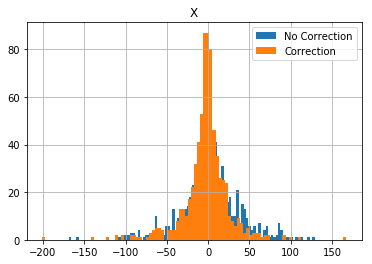

Y
Y 0.2601775118355797 37.83481817242806 -1.3560823303680198 37.83625559948718


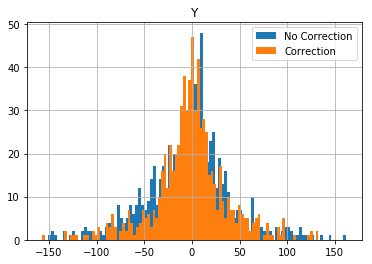

46.57
33.93
In px:  27.74 &  17.59 &  21.46 &  41.82 &  29.62 &  29.54 &  36.10 &  30.24
In mm:  5.3 &  3.3 &  4.1 &  7.9 &  5.6 &  5.6 &  6.9 &  5.7
Which therefore reduced the touch offset on the validation set by 22.5.


In [20]:
kernel = "rbf"  
dataX = [22, 3]
dataY = [16, 2]
df = dfValidation.copy()
for direction in ["X", "Y"]:
    print (direction)
    model = joblib.load('%s/Model_RF_%s.pkl' % (OUTPUT_PATH, direction)) 
    
    X_test = dfValidation[["SpeedCondition", "TouchX", "TouchY", 'Acc', 'RelativeTimePeak', 'PeakValue']].values
    y_rbf = model.predict(X_test)
    if (direction == "X"):
        df["TouchOffsetXPred"] = y_rbf
        score = model.score(X_test, df.TouchOffsetX.values)
        rmse = np.sqrt(sklearn.metrics.mean_squared_error(df.TouchOffsetX.values, df.TouchOffsetXPred))
        m = (df.TouchX-df.VisualStimuliPositionX-df.TouchOffsetXPred).mean()
        sd = (df.TouchX-df.VisualStimuliPositionX-df.TouchOffsetXPred).std()
        
    elif (direction == "Y"):
        df["TouchOffsetYPred"] = y_rbf
        score = model.score(X_test, df.TouchOffsetY.values)
        rmse = np.sqrt(sklearn.metrics.mean_squared_error(df.TouchOffsetY.values, df.TouchOffsetYPred))
        m = (df.TouchY-df.VisualStimuliPositionY-df.TouchOffsetYPred).mean()
        sd = (df.TouchY-df.VisualStimuliPositionY-df.TouchOffsetYPred).std()
    
    print (direction, score, rmse, m, sd)
    
    if (direction == "X"):
        (df.TouchX-df.VisualStimuliPositionX).hist(bins=100, label="No Correction")
        (df.TouchX-df.VisualStimuliPositionX-df.TouchOffsetXPred).hist(bins=100, label="Correction")
    else:
        (df.TouchY-df.VisualStimuliPositionY).hist(bins=100, label="No Correction")
        (df.TouchY-df.VisualStimuliPositionY-df.TouchOffsetYPred).hist(bins=100, label="Correction")
    plt.title(direction)
    plt.legend()
    plt.show()
distanceX = df.TouchX-df.VisualStimuliPositionX
distanceY = df.TouchY-df.VisualStimuliPositionY
distanceXCorr = df.TouchX-df.VisualStimuliPositionX-df.TouchOffsetXPred
distanceYCorr = df.TouchY-df.VisualStimuliPositionY-df.TouchOffsetYPred

offset = np.sqrt((distanceX*distanceX) + (distanceY*distanceY))
offsetCorr = np.sqrt((distanceXCorr*distanceXCorr) + (distanceYCorr*distanceYCorr))
print(offset.mean().round(2))
print(offset.std().round(2))

print("In px: ", end='')
for x in np.array(lst).flatten():
    print(" %.2f & " % x, end='')
print(" %.2f & " % offsetCorr.mean(), end='')
print(" %.2f" % offsetCorr.std(), end='')

print("")
print("In mm: ", end='')
for x in np.array(lst).flatten():
    print(" %.1f & " % (x*pxToMm), end='')
print(" %.1f & " % (offsetCorr.mean()*pxToMm), end='')
print(" %.1f" % (offsetCorr.std()*pxToMm), end='')

overallValidation = np.sqrt((dfValidation.TouchOffsetX*dfValidation.TouchOffsetX + (dfValidation.TouchOffsetY*dfValidation.TouchOffsetY)))
overallValidationP = ((1-offsetCorr.mean()/overallValidation.mean())*100)
print("")
print('Which therefore reduced the touch offset on the validation set by %.1f.' % overallValidationP)